In [32]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics import tsaplots

In [4]:
# Import train data
ne_train = pd.read_csv("/Users/Huey.ts/Desktop/STAT_390/data/ne_train.csv")
s_train = pd.read_csv("/Users/Huey.ts/Desktop/STAT_390/data/s_train.csv")

# Import test data
ne_test = pd.read_csv("/Users/Huey.ts/Desktop/STAT_390/data/ne_test.csv")
s_test = pd.read_csv("/Users/Huey.ts/Desktop/STAT_390/data/s_test.csv")

In [5]:
ne_train_transformed = pd.merge(ne_train.date, ne_train["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)
ne_test_transformed = pd.merge(ne_test.date, ne_test["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)
ne_train_transformed.set_index("date", inplace = True)
ne_test_transformed.set_index("date", inplace = True)

In [42]:
ne_test_transformed.index = pd.to_datetime(ne_test_transformed.index)

In [6]:
s_train_transformed = pd.merge(s_train.date, s_train["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)
s_test_transformed = pd.merge(s_test.date, s_test["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)
s_train_transformed.set_index("date", inplace = True)
s_test_transformed.set_index("date", inplace = True)

In [43]:
s_test_transformed.index = pd.to_datetime(ne_test_transformed.index)

# Auto-ARIMA Models
- Uses KPSS unit root --> select d
- Uses AIC information criteria --> select p, q
- stepwise = False --> fitting all (or a random subset of) hyper-parameter combinations
- seasonal = False --> no seasonality

## NE Model
- Residual stats show that residual looks like white noise with normal distribution and mean around 0
- ACF and PACF plots of residuals show barely any significant spikes for larger lags
    - Residuals are close to white noise
- Visualization of train data fitted values shows over-fitting
- MAE is reasonably good (399 confirmed cases)
    - Improvement from ARIMA

In [21]:
ne_auto_arima = auto_arima(ne_train_transformed, stepwise = False, seasonal = False)

In [22]:
ne_auto_arima

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

In [23]:
ne_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  191
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1603.620
Date:                Thu, 09 Nov 2023   AIC                           3219.241
Time:                        02:40:44   BIC                           3238.723
Sample:                    01-22-2020   HQIC                          3227.133
                         - 07-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.4008     54.077     -0.026      0.979    -107.391     104.589
ar.L1          1.2612      0.038     33.331      0.000       1.187       1.335
ar.L2         -0.9195      0.040    -23.048      0.000      -0.998      -0.841
ma.L1         -1.3637      0.056    -24.215      0.000      -1.474      -1.253
ma.L2          0.8719      0.053     16.597      0.000       0.769       0.975
sigma2      1.255e+06   5.59e+04     22.452      0.000    1.15e+06    1.36e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):              1440.40
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             1.83
Prob(H) (two-sided):                  0.69   Kurtosis:                        15.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
auto_arima = ARIMA(ne_train_transformed, order=(2,1,2))
auto_arima = auto_arima.fit()

/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


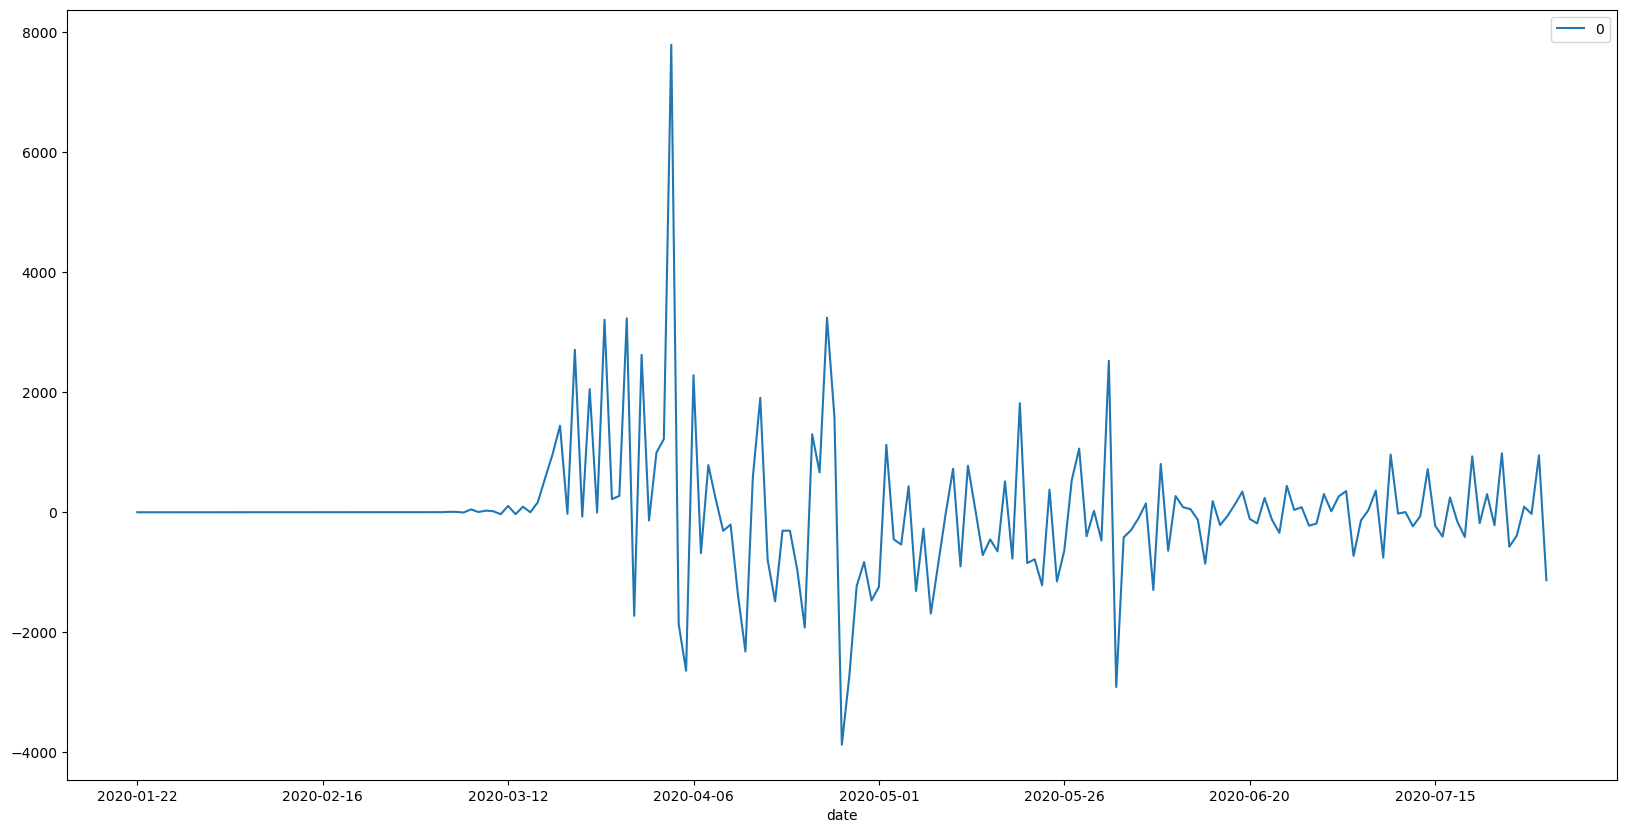

In [27]:
# line plot of residuals
residuals = pd.DataFrame(auto_arima.resid)
residuals.plot(figsize = (20,10))
plt.show()

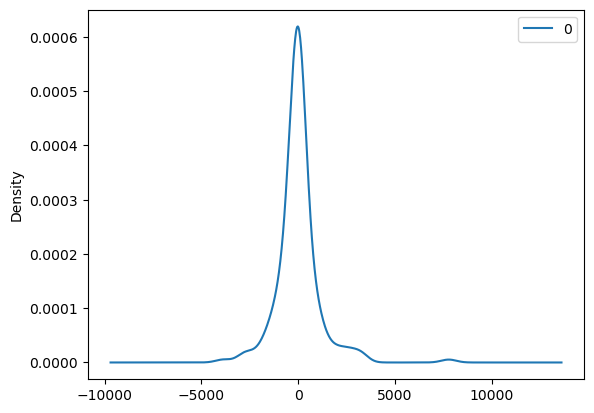

In [28]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

In [29]:
# summary stats of residuals
print(residuals.describe())

                 0
count   191.000000
mean     16.272993
std    1116.312802
min   -3871.971139
25%    -307.146090
50%       0.000000
75%     200.027199
max    7787.320216


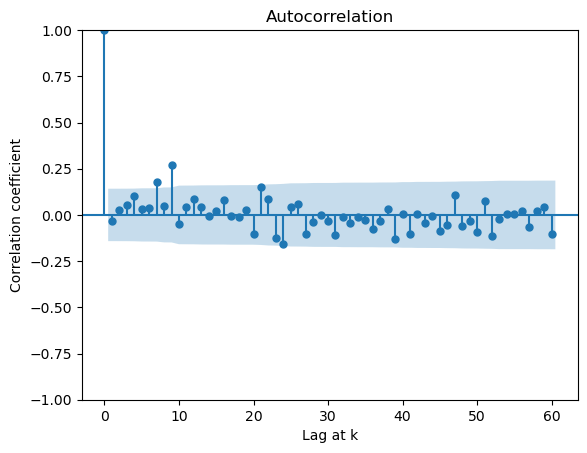

In [33]:
# ACF plot of residuals
fig = tsaplots.plot_acf(residuals, lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

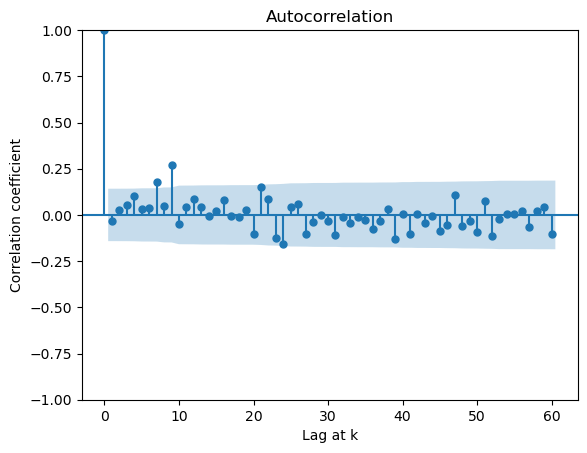

In [34]:
# PACF plot of residuals
fig = tsaplots.plot_acf(residuals, lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

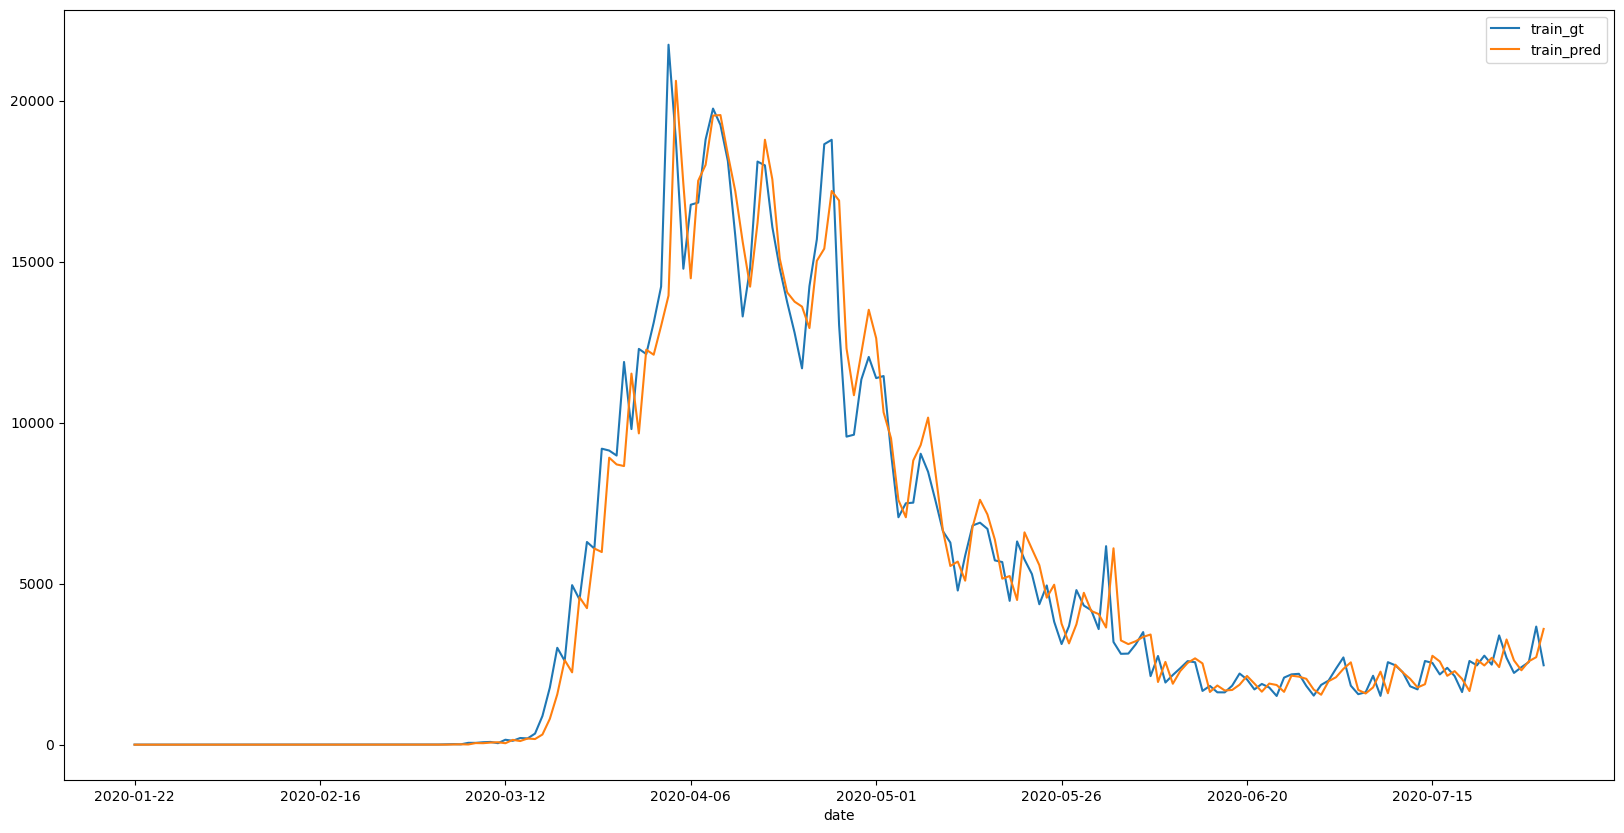

In [36]:
# Visualizing train data fitted values
ne_train_pred = ne_auto_arima.fittedvalues()
pd.concat([ne_train_transformed, ne_train_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

In [52]:
ne_test_pred = ne_auto_arima.predict(n_periods=len(ne_test_transformed))

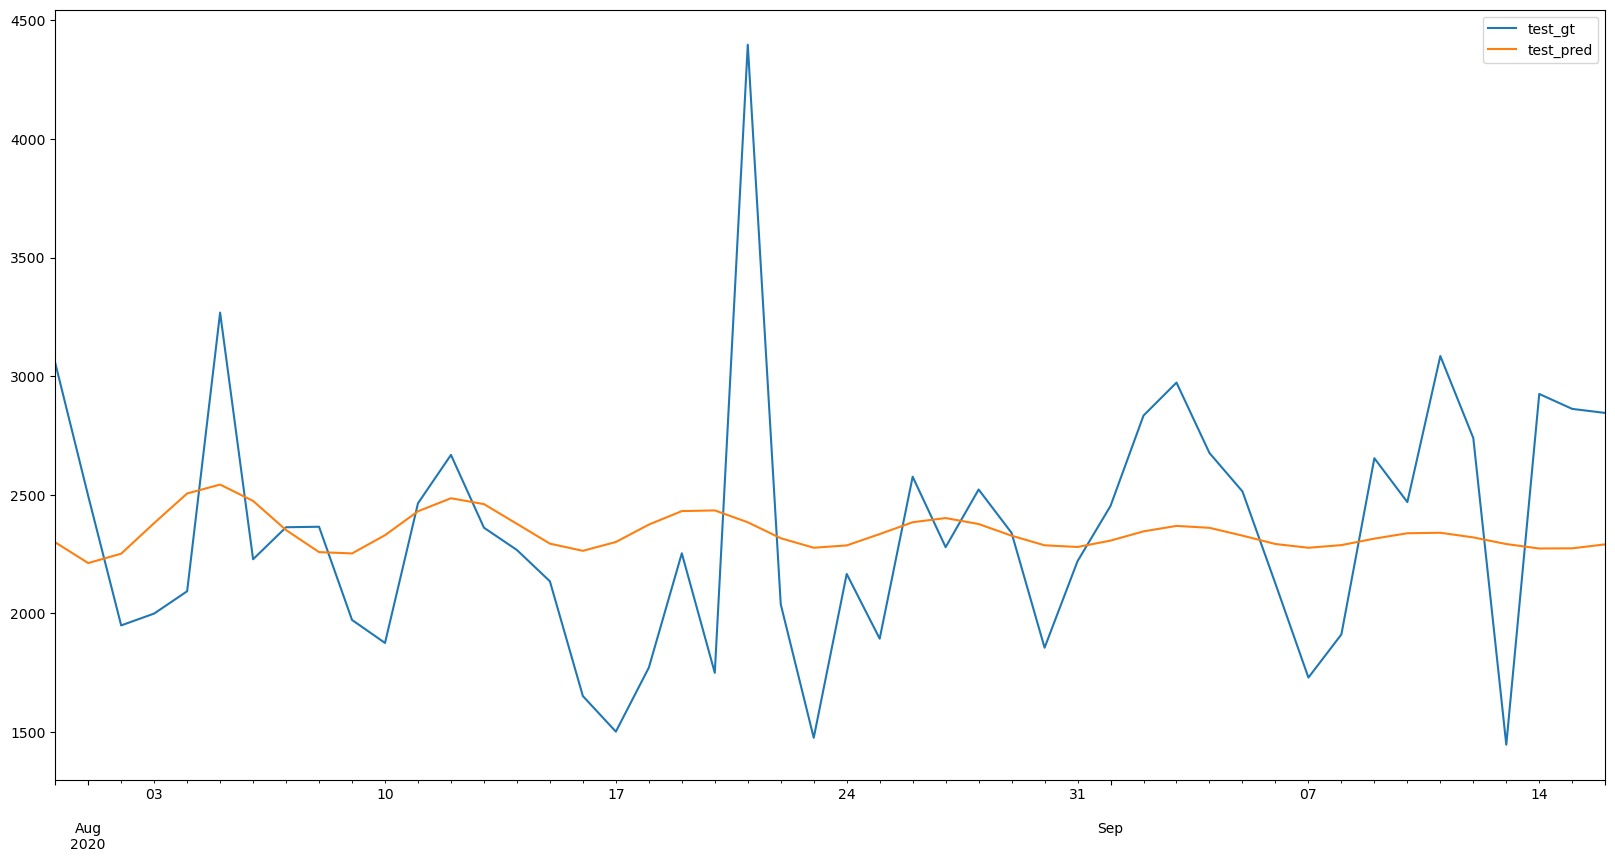

In [53]:
# Visualizing test data fitted values
pd.concat([ne_test_transformed, ne_test_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [55]:
# MAE
mean_absolute_error(ne_test_transformed, ne_test_pred)

398.9677044947518

## S Model
- Residual stats show that residual looks like white noise with normal distribution but mean not close to 0
    - Some bias in prediction
    - More bias in prediction than ARIMA
- ACF and PACF plots of residuals show barely any significant spikes for larger lags
    - Residuals are close to white noise
- Visualization of train data fitted values shows over-fitting
- MAE is quite large (15447 confirmed cases)
    - Worse than ARIMA

In [56]:
s_auto_arima = auto_arima(s_train_transformed, stepwise = False, seasonal = False)

In [57]:
s_auto_arima

ARIMA(order=(5, 1, 0), scoring_args={}, suppress_warnings=True)

In [58]:
s_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  191
Model:               SARIMAX(5, 1, 0)   Log Likelihood               -1641.061
Date:                Thu, 09 Nov 2023   AIC                           3296.122
Time:                        02:49:36   BIC                           3318.852
Sample:                    01-22-2020   HQIC                          3305.330
                         - 07-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    359.9332    123.210      2.921      0.003     118.447     601.420
ar.L1         -0.3153      0.064     -4.919      0.000      -0.441      -0.190
ar.L2         -0.2106      0.057     -3.725      0.000      -0.321      -0.100
ar.L3         -0.2419      0.062     -3.923      0.000      -0.363      -0.121
ar.L4         -0.3534      0.049     -7.155      0.000      -0.450      -0.257
ar.L5         -0.2430      0.055     -4.438      0.000      -0.350      -0.136
sigma2      1.902e+06   1.56e+05     12.165      0.000     1.6e+06    2.21e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               109.75
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):              38.21   Skew:                             1.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
auto_arima = ARIMA(s_train_transformed, order=(5,1,0))
auto_arima = auto_arima.fit()

/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/Huey.ts/miniconda3/envs/tf/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


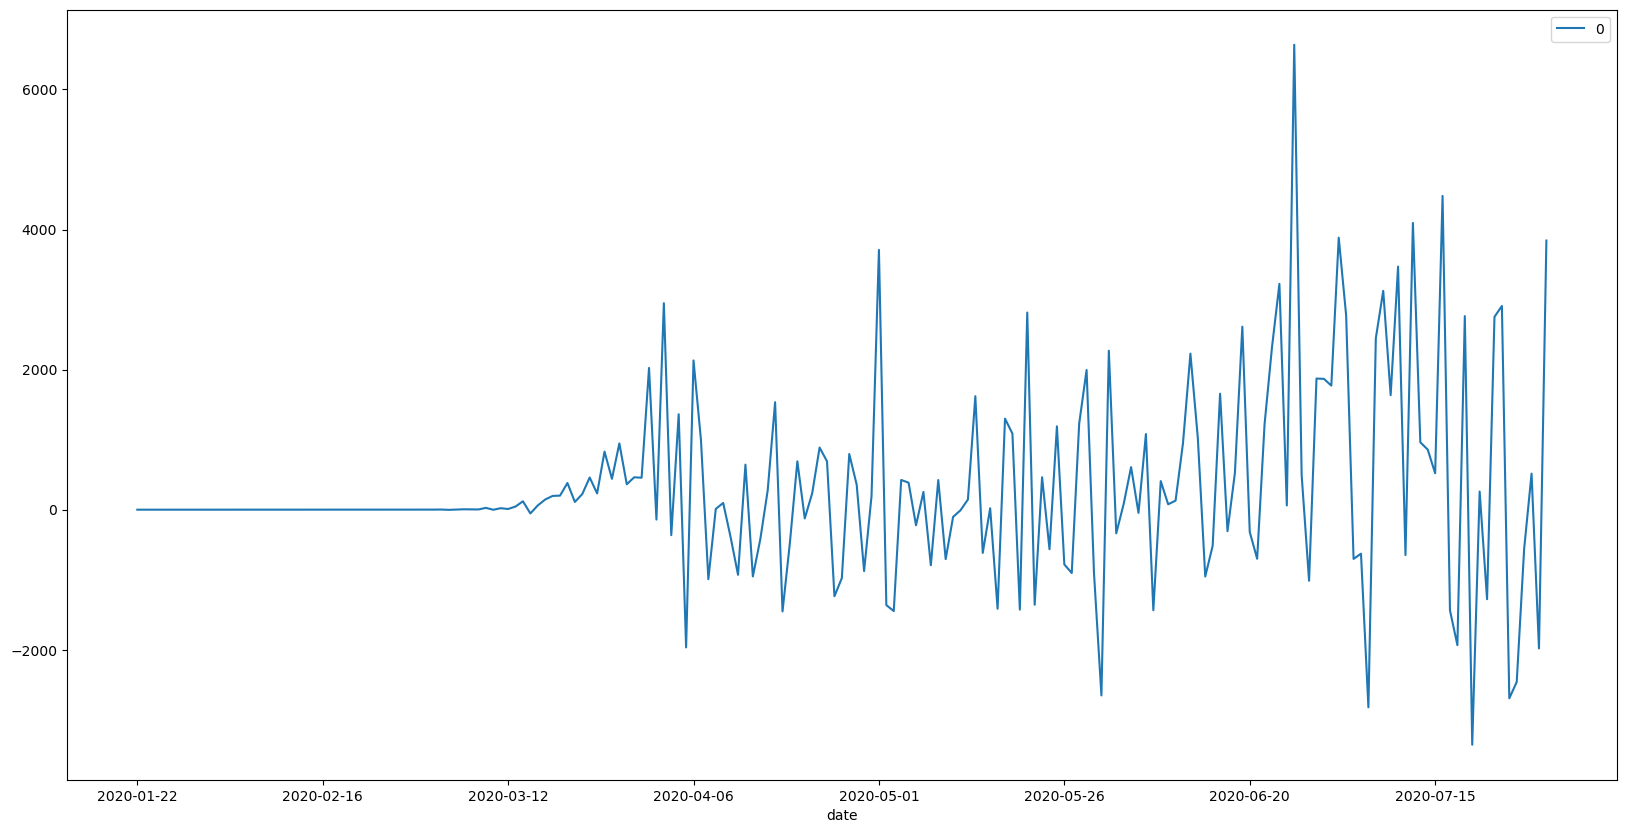

In [60]:
# line plot of residuals
residuals = pd.DataFrame(auto_arima.resid)
residuals.plot(figsize = (20,10))
plt.show()

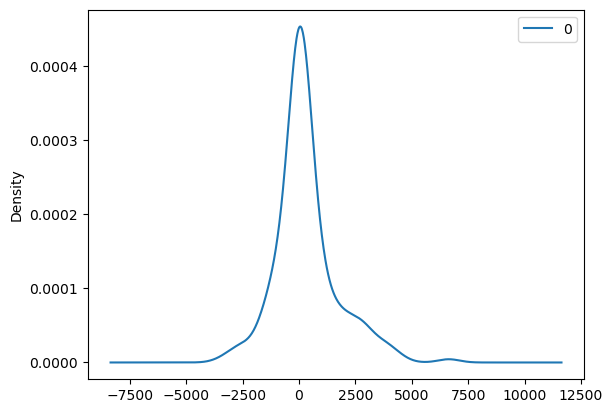

In [61]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

In [62]:
# summary stats of residuals
print(residuals.describe())

                 0
count   191.000000
mean    315.898221
std    1366.467241
min   -3355.559195
25%    -113.859613
50%       1.720521
75%     666.690495
max    6638.231916


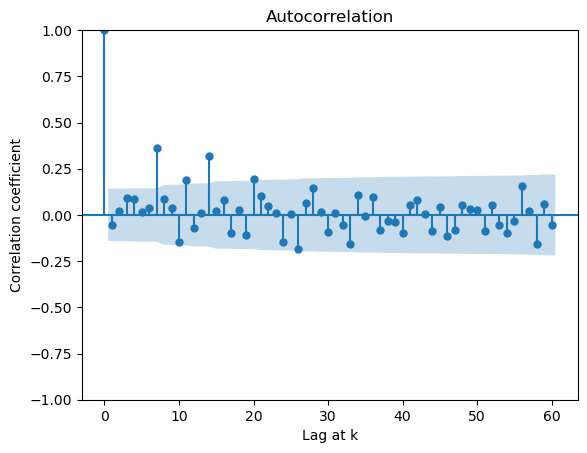

In [63]:
# ACF plot of residuals
fig = tsaplots.plot_acf(residuals, lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

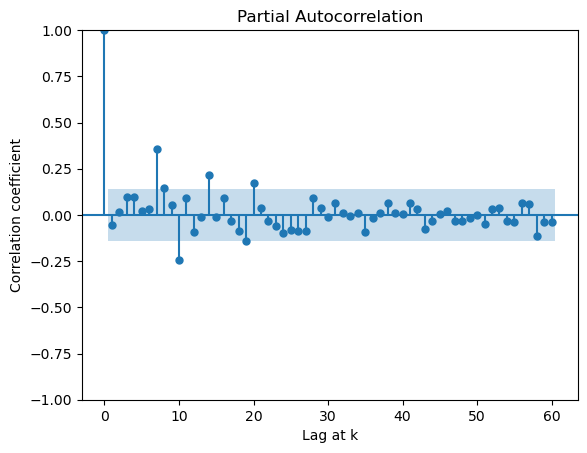

In [64]:
# ACF plot of residuals
fig = tsaplots.plot_pacf(residuals, lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

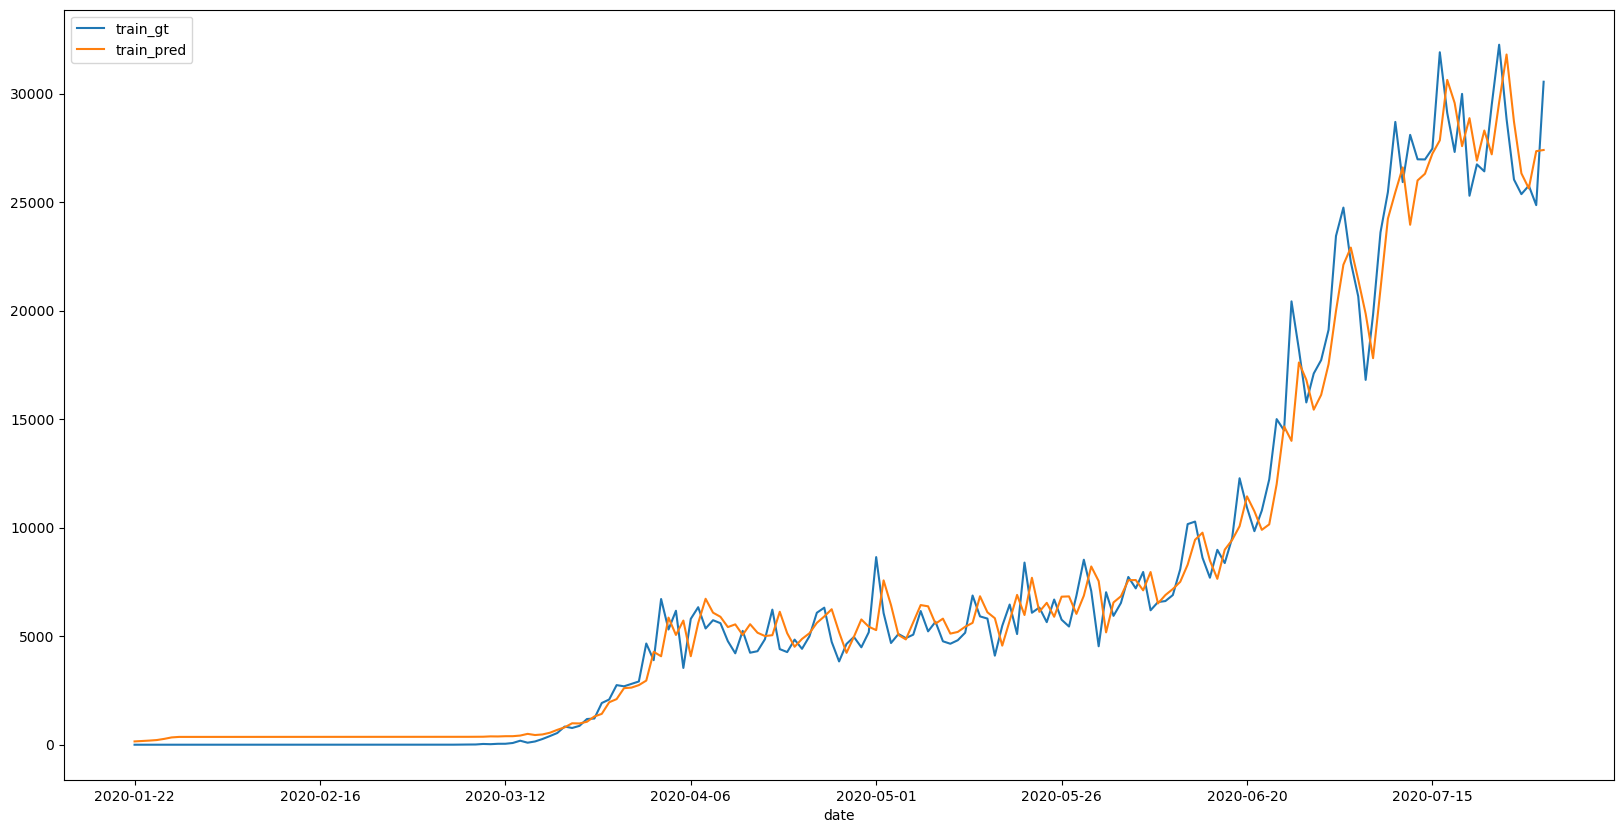

In [65]:
# Visualizing train data fitted values
s_train_pred = s_auto_arima.fittedvalues()
pd.concat([s_train_transformed, s_train_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

In [66]:
s_test_pred = s_auto_arima.predict(n_periods=len(s_test_transformed))

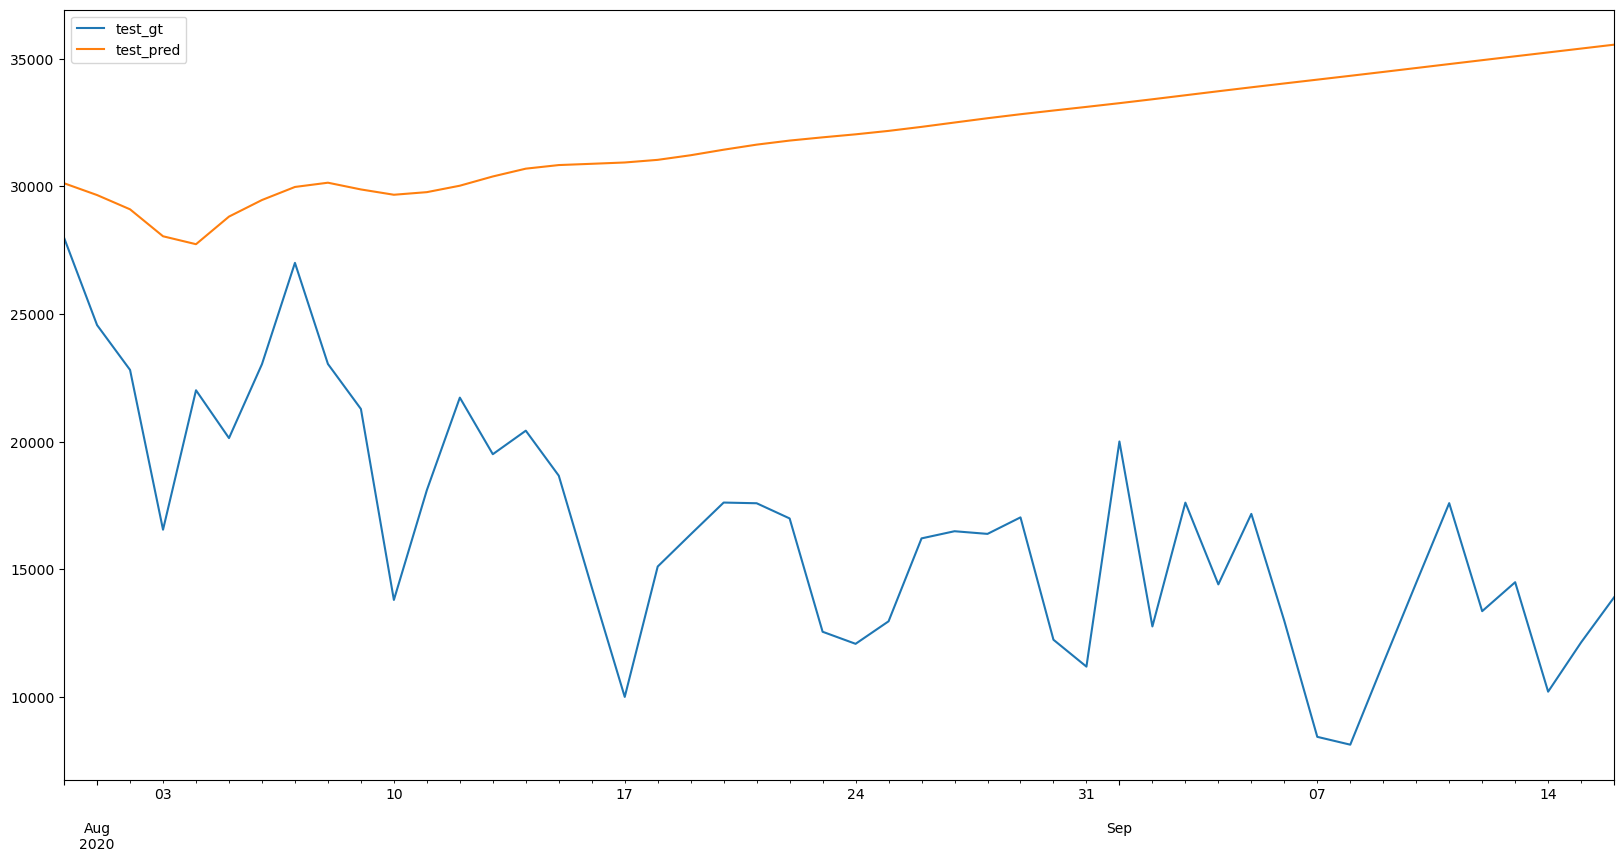

In [67]:
# Visualizing test data fitted values
pd.concat([s_test_transformed, s_test_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [68]:
# MAE
mean_absolute_error(s_test_transformed, s_test_pred)

15447.941130030185